# Probability

In [15]:
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import reduce, partial
from itertools import count, combinations, islice
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random, randint, choice
from time import time
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

-----

# A) Girl/Boy Proportion Problem

- All parents have a new child until a boy is born.
- A new child is boy or girl with equal probability.
- Start with the 50/50 proportion.
- What will be the proportion of boys?

Intuition: it should stay 50 %, because the probability of a new child is always 50 %. It can be also verified though geometric distribution, but instead, we will use a simulation to compute the proportion.

I will assume that families are formed by a maximum matching (i.e. if there are 100 men and 90 women in the population, there will be 90 families). Due to a random variation in the number of born children, I guess this will cause a decreasing population (but the ratio should stay about 0.5 unless the population ceases to exist).

In [33]:
GIRL, BOY = 0, 1

def compute_proportion(n_people=1000, n_iter=50, p_boy=0.5):
    populations = generate_populations(n_people, p_boy, n_iter)
    population = list(populations)[-1]
    return sum(population) / len(population) if population else 0

def generate_populations(n_people=1000, p_boy=0.5, n_iter=50):
    population = [choice([GIRL, BOY]) for _ in range(n_people)]
    for _ in range(n_iter):
        yield population
        population = create_new_population(population, p_boy)

def create_new_population(population, p_boy):
    n_families = min(population.count(g) for g in [GIRL, BOY])
    new_population = []
    for _ in range(n_families):
        child = None
        while child != BOY:
            child = BOY if random() < p_boy else GIRL
            new_population.append(child)
    return new_population
         
compute_proportion()

0.49615384615384617

Let's repeat the experiment multiple times to get a more reliable estimates:

In [34]:
results = pd.Series([compute_proportion() for _ in range(100)])
results.describe()

count    100.000000
mean       0.498361
std        0.077518
min        0.000000
25%        0.474025
50%        0.503001
75%        0.531823
max        0.666667
dtype: float64

We see that both the mean and median are close to 0.5. Let's plot a graph to see how much the population decrease over time:

Proportion over time:
count    50.000000
mean      0.503936
std       0.029460
min       0.427083
25%       0.489004
50%       0.503174
75%       0.517800
max       0.594059
dtype: float64


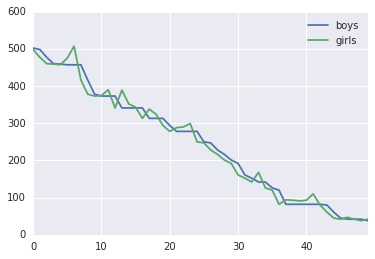

In [40]:
def plot_generations(n_people=1000, n_iter=50, p_boy=0.5):
    boys, girls = [], []
    for population in generate_populations(n_people, p_boy, n_iter):
        boys.append(population.count(BOY))
        girls.append(population.count(GIRL))
    df = pd.DataFrame({'boys': boys, 'girls': girls})
    df.plot()
    proportion = df.boys / (df.boys + df.girls)
    print('Proportion over time:\n' + str(proportion.describe()))
    
plot_generations()

Now let's explore what happens when the we change the probability of a boy being born. If we increase the probability for boys, then the number of girls in the population will decrease more rapidly (the number of boys will then decrease in the same speed, but with a single generation delay):

Proportion over time:
count    27.000000
mean      0.569561
std       0.112666
min       0.466019
25%       0.500000
50%       0.539683
75%       0.589476
max       1.000000
dtype: float64


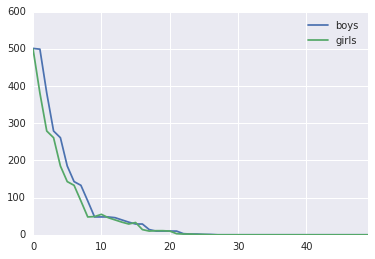

In [44]:
plot_generations(n_people=1000, n_iter=50, p_boy=0.55)

If we increase the probability for girl, than the size of the population will not decrease, because in every generation, there will be as many boys as there are families and even more girls. The number of girls will be constant+noise, where the constant could be easily computed using a geometric distribution.

Proportion over time:
count    50.000000
mean      0.306115
std       0.028011
min       0.274620
25%       0.297652
50%       0.302167
75%       0.308959
max       0.488000
dtype: float64


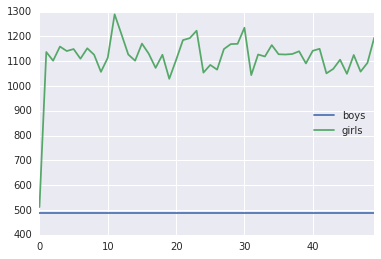

In [46]:
plot_generations(n_people=1000, n_iter=50, p_boy=0.3)

-----

# B) Nonrandom Numbers

TODO:
- ...

In [14]:
for i in range(1, 8):    
    with open('random/random{0}.txt'.format(i)) as f:
        numbers = list(map(int, f.read().split()))
        print('random' + str(i) + ':')
        # Analysis of frequences of numbers
        print(Counter(numbers))
        # Analysis of bigrams
        bigrams = [
            str(numbers[i]) + str(numbers[i+1])
            for i in range(len(numbers)-1)]
        print('distinct birgrams', len(set(bigrams)))
        #print(Counter(bigrams))
        print()
        
# Probably not random:
# 1 ...
# 2 (1-grams: 1244x number 5)
# 4 (2-grams: only 18 from 36 possible pairs)
# TODO: frequency in every 2nd/3rd numbers
# TODO: Matrix of bigrams
# TODO: nejldelsi posloupnost, ktera se opakuje N-krat (2-krat?)
# TODO: ML approach - can we predict the last 30% of numbers

random1:
Counter({4: 834, 2: 834, 5: 833, 3: 833, 1: 833, 6: 833})
distinct birgrams 36

random2:
Counter({5: 1244, 1: 856, 4: 845, 3: 829, 6: 798, 2: 428})
distinct birgrams 36

random3:
Counter({6: 850, 3: 850, 2: 836, 4: 824, 5: 821, 1: 819})
distinct birgrams 36

random4:
Counter({1: 852, 4: 850, 3: 829, 2: 827, 6: 823, 5: 819})
distinct birgrams 18

random5:
Counter({6: 859, 4: 843, 5: 842, 2: 836, 3: 812, 1: 808})
distinct birgrams 36

random6:
Counter({2: 851, 3: 849, 1: 849, 4: 846, 5: 803, 6: 802})
distinct birgrams 36

random7:
Counter({2: 842, 1: 838, 4: 834, 5: 833, 6: 830, 3: 823})
distinct birgrams 36



In [15]:
6 * 999 / (6 * 999  + 9940)

0.3761767290071545

-----

# D) Bayes Theorem

Intuitive guesses for dice being fair:
- 10 dice, 5 rols: 0.3
- 100 dice, 3 rolls: 0.9 (should be 0.3)
- 1000 dice, 5 rolls: 0.5

Post comment: my intutition was absolutely wrong!

In [28]:
# First, using Bayes Theorem:

def compute_fair_probability(n_dice=100, n_rolls=3, n_faces=6):
    """Return probabilty of a dice taken randomly from a set
       of n_dice being fake, given that only one is fake,
       and given that we observe n_rolls of 6 in a row.
    """
    fake_prior = 1 / n_dice
    fake_conditional = 1
    fake_likelihood = fake_prior * fake_conditional
    
    fair_prior = 1 - fake_prior
    fair_conditional = 1 / (n_faces ** n_rolls)
    fair_likelihood = fair_prior * fair_conditional
    
    observation_probability = fake_likelihood + fair_likelihood
    fair_probability = fair_likelihood / observation_probability
    return fair_probability
    
settings = [(2, 1), (10, 5), (100, 3), (1000, 5)]
for n_dice, n_rolls in settings:
    prob = compute_fair_probability(n_dice, n_rolls)
    print('n={0} x={1} --> {2}'.format(n_dice, n_rolls, prob))

n=2 x=1 --> 0.14285714285714285
n=10 x=5 --> 0.0011560693641618498
n=100 x=3 --> 0.3142857142857143
n=1000 x=5 --> 0.11384615384615385


In [31]:
def simulate_fair_probability(n_dice=100, n_rolls=3, n_faces=6,
                              n_iter=100000):
    """The same as above, estimated by simulation.
    
    We will use simple rejection sampling.
    """
    n_success, n_total = 0, 0
    for i_iter in range(n_iter):
        if randint(1, n_dice) == n_dice:
            # fake dice
            n_total += 1
        else:
            for i_roll in range(n_rolls):
                if randint(1, n_faces) != n_faces:
                    break
            else:  # all rolls were 6
                n_success += 1
                n_total += 1    
    return n_success / n_total
    
settings = [(2, 1), (10, 5), (100, 3), (1000, 5)]
for n_dice, n_rolls in settings:
    prob = simulate_fair_probability(n_dice, n_rolls)
    print('n={0} x={1} --> {2}'.format(n_dice, n_rolls, prob))

n=2 x=1 --> 0.14637024369388626
n=10 x=5 --> 0.0014885382554331646
n=100 x=3 --> 0.31288766368022053
n=1000 x=5 --> 0.11818181818181818
